In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pytensor.tensor as at

from statsmodels.regression.linear_model import OLS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

In [4]:
# Generating predictors: 10 in total, first 5 multicollinear
n_obs = 100

# Generate 5 columns of uncorrelated N(0, 1) data
x_mean = 0
x_sd = 1
x_random = rng.normal(x_mean, x_sd, size = (n_obs, 5))

# Generate 5 columns of multicollinear data
means = [0, 0, 0, 0, 0]
covariances = r = np.array([
        [1.0, 0.6, 0.8, 0.4, 0.7],
        [0.6, 1.0, 0.8, 0.6, 0.4],
        [0.8, 0.8, 1.0, 0.8, 0.8],
        [0.4, 0.6, 0.8, 1.0, 0.6],
        [0.7, 0.4, 0.8, 0.6, 1.0]
    ])
x_correlated = rng.multivariate_normal(means, covariances, size = n_obs)

# Combine them
x = np.concatenate([x_correlated, x_random], axis = 1)
x = pd.DataFrame(x)
xarray = xr.DataArray(x, dims = ("rows", "predictors")) # For plotting with arviz

In [5]:
# Check the correlation matrix of predictors
np.corrcoef(x_random, rowvar = False)

array([[ 1.        ,  0.06178445,  0.02751957, -0.15869338, -0.09388627],
       [ 0.06178445,  1.        ,  0.06173015, -0.0179062 , -0.19199826],
       [ 0.02751957,  0.06173015,  1.        ,  0.07580967, -0.18663197],
       [-0.15869338, -0.0179062 ,  0.07580967,  1.        ,  0.07693846],
       [-0.09388627, -0.19199826, -0.18663197,  0.07693846,  1.        ]])

In [6]:
# Check the correlation matrix of predictors
np.corrcoef(x_correlated, rowvar = False)

array([[1.        , 0.66838044, 0.79724243, 0.48437181, 0.6537348 ],
       [0.66838044, 1.        , 0.84808524, 0.72516445, 0.43040894],
       [0.79724243, 0.84808524, 1.        , 0.85951921, 0.78368936],
       [0.48437181, 0.72516445, 0.85951921, 1.        , 0.619859  ],
       [0.6537348 , 0.43040894, 0.78368936, 0.619859  , 1.        ]])

In [7]:
# Relationship & link function
true_intercept = 0.5
true_slopes = [0.9, -0.3, 0.4, 0, 0, 0, 0, 0, 0, 0] # Only the first 3 columns have a real effect
true_line = true_intercept + x.dot(true_slopes)

# Target
noise_mean = 0
noise_sd = 1
noise = rng.normal(noise_mean, noise_sd, size = n_obs)
y = true_line + noise

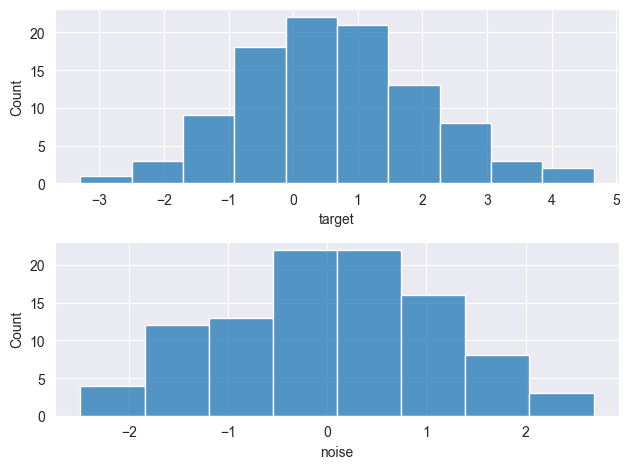

In [8]:
# Distributions of data
fig, ax = plt.subplots(2)

_ = sns.histplot(y, ax = ax[0])
_ = ax[0].set_xlabel("target")

_ = sns.histplot(noise, ax = ax[1])
_ = ax[1].set_xlabel("noise")

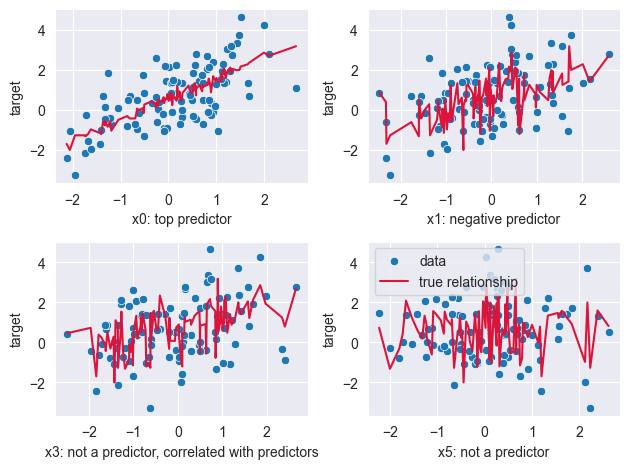

In [9]:
# True relationships
fig, ax = plt.subplots(2, 2)

_ = sns.scatterplot(x = x[0], y = y, ax = ax[0, 0])
_ = sns.lineplot(x = x[0], y = true_line, color = "crimson", ax = ax[0, 0])
_ = ax[0, 0].set_xlabel("x0: top predictor")
_ = ax[0, 0].set_ylabel("target")

_ = sns.scatterplot(x = x[1], y = y, ax = ax[0, 1])
_ = sns.lineplot(x = x[1], y = true_line, color = "crimson", ax = ax[0, 1])
_ = ax[0, 1].set_xlabel("x1: negative predictor")
_ = ax[0, 1].set_ylabel("target")

_ = sns.scatterplot(x = x[3], y = y, ax = ax[1, 0])
_ = sns.lineplot(x = x[3], y = true_line, color = "crimson", ax = ax[1, 0])
_ = ax[1, 0].set_xlabel("x3: not a predictor, correlated with predictors")
_ = ax[1, 0].set_ylabel("target")

_ = sns.scatterplot(x = x[5], y = y, label = "data", ax = ax[1, 1])
_ = sns.lineplot(x = x[5], y = true_line, label = "true relationship", color = "crimson", ax = ax[1, 1])
_ = ax[1, 1].set_xlabel("x5: not a predictor")
_ = ax[1, 1].set_ylabel("target")

## Frequentist OLS

In [10]:
exog = x.copy()
exog["constant"] = np.ones(n_obs)

In [11]:
ols = OLS(endog = y, exog = exog)

In [12]:
ols_res = ols.fit()
ols_fitted = ols.predict(ols_res.params, exog)

In [13]:
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     7.939
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           5.27e-09
Time:                        11:40:54   Log-Likelihood:                -148.28
No. Observations:                 100   AIC:                             318.6
Df Residuals:                      89   BIC:                             347.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.7662      0.255      3.001      0.003       0.259       1.273
1             -0.5889      0.305     -1.931      0.057      -1.195       0.017
2              1.2563      0.637      1.971      0.052      -0.010       2.523
3             -0.2652      0.291     -0.912      0.364      -0.843       0.313
4             -0.4370      0.258     -1.695      0.094      -0.949       0.075
5             -0.0380      0.119     -0.318      0.751      -0.275       0.199
6              0.1306      0.118      1.106      0.272      -0.104       0.365
7             -0.1000      0.118     -0.849      0.398      -0.334       0.134
8              0.0210      0.113      0.186      0.853      -0.203       0.245
9             -0.0588      0.115     -0.513      0.609      -0.286       0.169
constant       0.4893      0.120      4.084      0.000       0.251       0.727
==============================================================================
Omnibus:                        1.260   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                1.332
Skew:                           0.248   Prob(JB):                        0.514
Kurtosis:                       2.729   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Very close intercept point estimate.
Actual predictor estimates off.
Correlated non-predictor estimates off.
Non-predictor estimates decent.

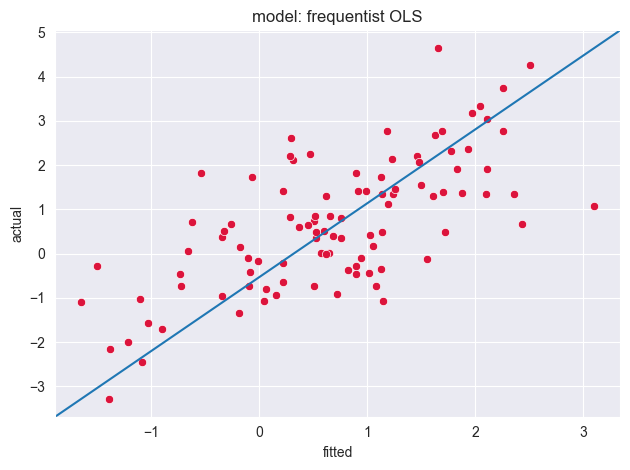

In [14]:
fig, ax = plt.subplots(1)
_ = sns.scatterplot(x = ols_fitted, y = y, color = "crimson", ax = ax)
_ = ax.plot([0, 1], [0, 1], transform=ax.transAxes)
_ = ax.set_xlabel("fitted")
_ = ax.set_ylabel("actual")
_ = ax.set_title("model: frequentist OLS")

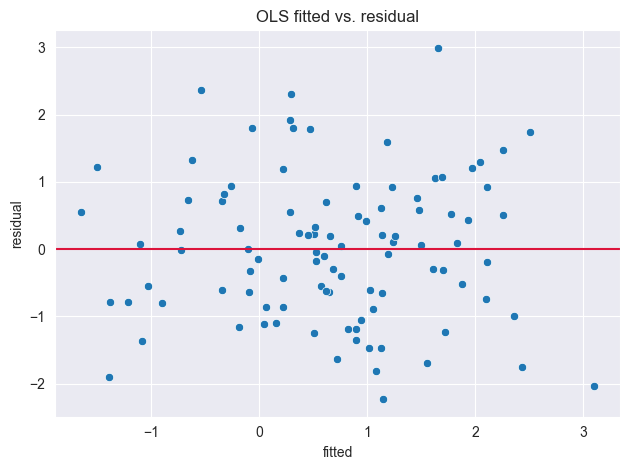

In [15]:
ols_resids = y - ols_fitted
_ = sns.scatterplot(x = ols_fitted, y = ols_resids)
_ = plt.axhline(0, c = "crimson")
_ = plt.title("OLS fitted vs. residual")
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

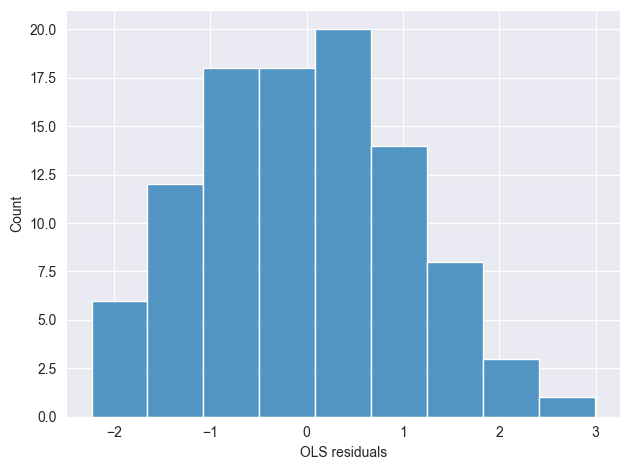

In [16]:
_ = sns.histplot(ols_resids)
_ = plt.xlabel("OLS residuals")

In [17]:
print(f"RMSE OLS fitted: {np.round(np.sqrt(np.mean(ols_resids**2)), 2)}" )

RMSE OLS fitted: 1.07


## Flat prior

In [18]:
# Create model
flat_model = pm.Model(
    coords = {
        "rows": x.index.values,
        "predictors": x.columns.values
    }
)

In [19]:
# Define priors & likelihood
with flat_model:

    # Data
    x_data = pm.MutableData("x_data", x, dims = ("rows", "predictors"))
    y_data = pm.MutableData("y_data", y, dims = "rows")

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 5) 
    slope = pm.Normal("slope", mu = 0, sigma = 5, dims = "predictors") 
    error = pm.HalfNormal("error", sigma = 5)

    # Expected value
    mean = pm.Deterministic(
        "mean", 
        intercept + at.dot(x_data, slope),
        dims = "rows"
    )

    # Likelihood
    likelihood = pm.Normal(
        "outcome", 
        mu = mean, 
        sigma = error, 
        observed = y_data,
        dims = "rows"
    )

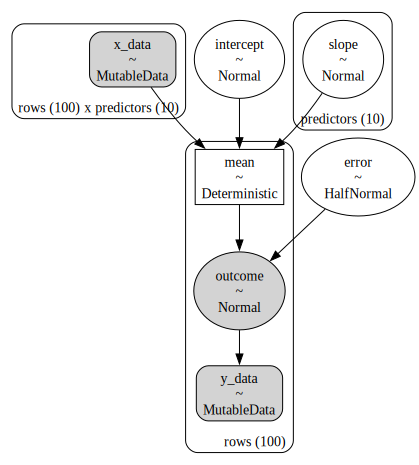

In [20]:
# View model diagram
pm.model_to_graphviz(flat_model)

In [21]:
# Draw posterior samples
with flat_model:
    flat_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [22]:
# Sample outcome variable from posterior
with flat_model:
    pm.sample_posterior_predictive(flat_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


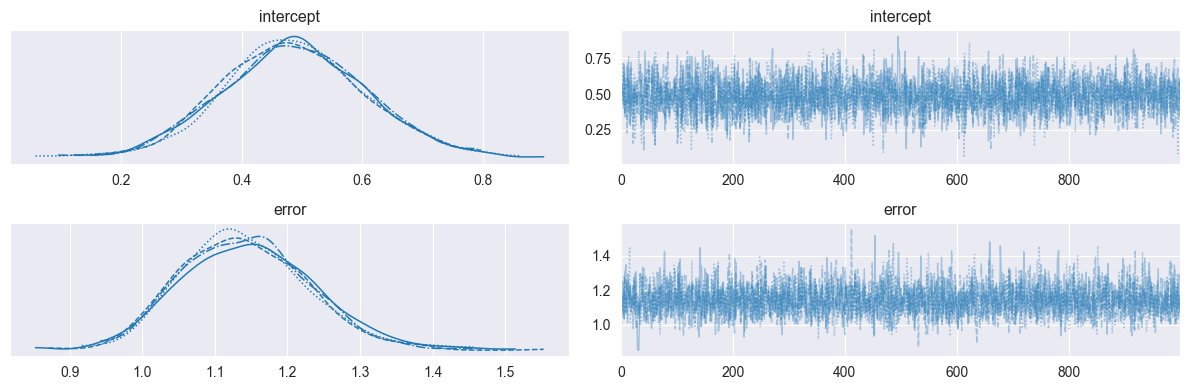

In [23]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    flat_posterior,
    var_names = ["intercept", "error"]
)

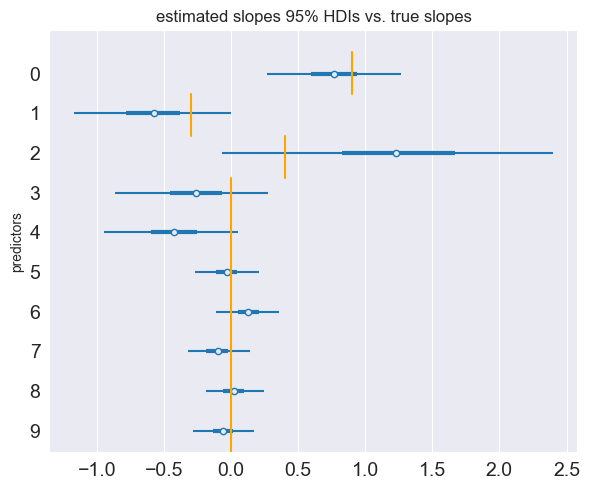

In [24]:
# Plot distributions for slope estimates
_ = pm.plot_forest(
    flat_posterior,
    var_names=["slope"],
    combined=True,
    labeller=az.labels.NoVarLabeller(),
    hdi_prob = 0.95
    #kind = "ridgeplot",
    #ridgeplot_alpha = 0.3
)
_ = plt.axvline(true_slopes[0], ymin = 0.85, ymax = 0.95, c = "orange")
_ = plt.axvline(true_slopes[1], ymin = 0.75, ymax = 0.85,  c = "orange")
_ = plt.axvline(true_slopes[2], ymin = 0.65, ymax = 0.75,  c = "orange")
_ = plt.axvline(0, ymin = 0, ymax = 0.65, c = "orange")
_ = plt.title("estimated slopes 95% HDIs vs. true slopes")
_ = plt.ylabel("predictors")

In [25]:
# Simulate fitted regression lines
flat_fitted = flat_posterior.posterior["mean"]

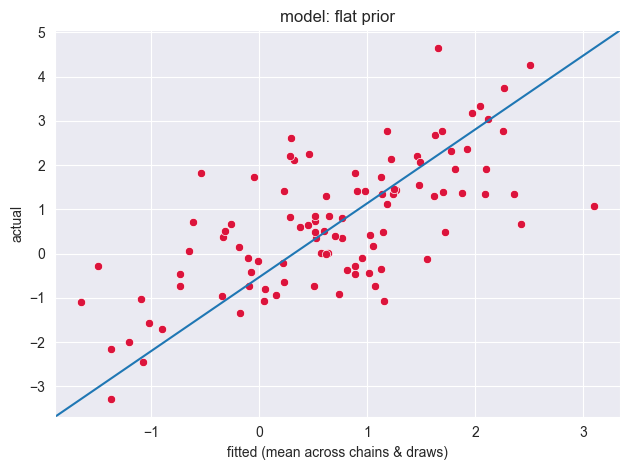

In [26]:
# Plot fitted vs. actual values
fig, ax = plt.subplots(1)
_ = sns.scatterplot(
    x = flat_fitted.mean(("chain", "draw")), 
    y = y, 
    color = "crimson", 
    ax = ax)
_ = ax.plot([0, 1], [0, 1], transform=ax.transAxes)
_ = ax.set_xlabel("fitted (mean across chains & draws)")
_ = ax.set_ylabel("actual")
_ = ax.set_title("model: flat prior")

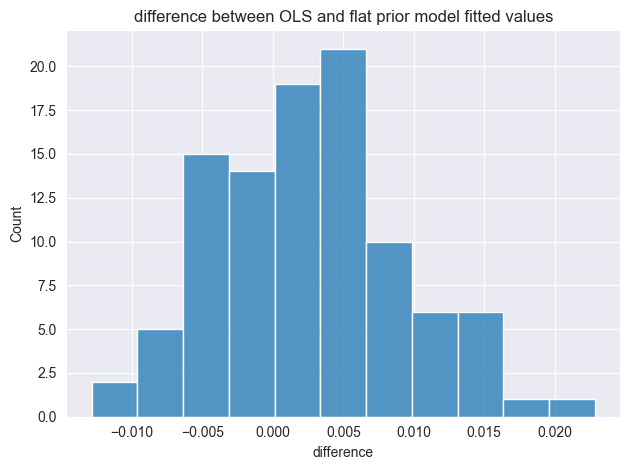

In [27]:
# Almost the same fitted values as OLS
_ = sns.histplot(ols_fitted - flat_fitted.mean(("chain", "draw")))
_ = plt.title("difference between OLS and flat prior model fitted values")
_ = plt.xlabel("difference")

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


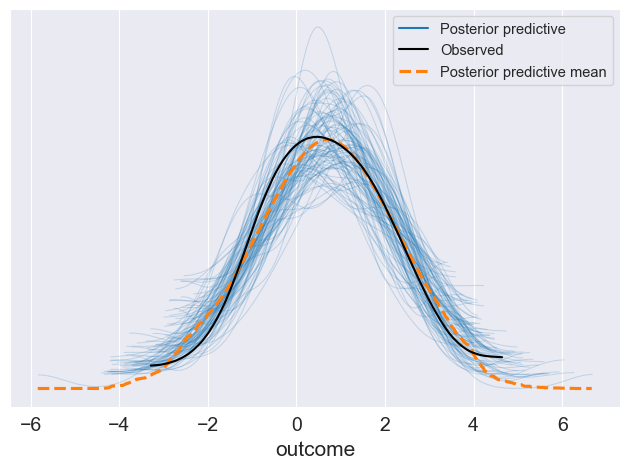

In [28]:
# Plot posterior distribution
_ = az.plot_ppc(flat_posterior, num_pp_samples = 100)

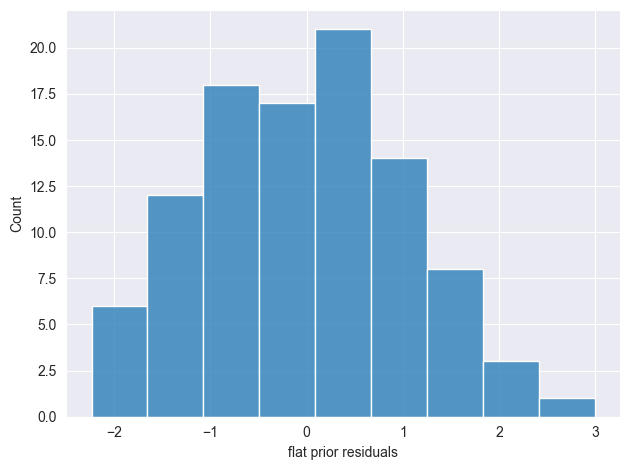

In [29]:
flat_resids = y - flat_fitted.mean(("chain", "draw"))
_ = sns.histplot(flat_resids)
_ = plt.xlabel("flat prior residuals")

In [30]:
print(f"RMSE flat fitted: {np.round(np.sqrt(np.mean(flat_resids**2)), 2)}" )

RMSE flat fitted: 1.07


## Flat + regularized prior

In [31]:
D = 10 # Number of predictors
D0 = 5 # N. of expected significant predictors

In [32]:
# Create model
regularized_model = pm.Model(
    coords = {
        "rows": x.index.values,
        "predictors": x.columns.values
    }
)

In [33]:
# Define priors & likelihood
with regularized_model:

    # Data
    x_data = pm.MutableData("x_data", x, dims = ("rows", "predictors"))
    y_data = pm.MutableData("y_data", y, dims = "rows")

    # Error & intercept priors
    intercept = pm.Normal("intercept", mu = 0, sigma = 5) 
    error = pm.HalfNormal("error", sigma = 5)

    # Global shrinkage prior
    tau = pm.HalfStudentT(
        "tau",
        nu = 2,
        sigma = (D0 / (D-D0)) * error / np.sqrt(n_obs)
    )

    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", nu = 5, sigma = 1, dims = "predictors")
    c2 = pm.InverseGamma("c2", alpha = 1, beta = 1)
    z = pm.Normal("z", mu = 0, sigma = 1, dims = "predictors")

    # Regularized coefficients
    slope = pm.Deterministic(
        "slope",
        z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)),
        dims = "predictors"
    )

    # Expected value
    mean = pm.Deterministic(
        "mean", 
        intercept + at.dot(x_data, slope),
        dims = "rows"
    )

    # Likelihood
    likelihood = pm.Normal(
        "outcome", 
        mu = mean, 
        sigma = error, 
        observed = y_data,
        dims = "rows"
    )

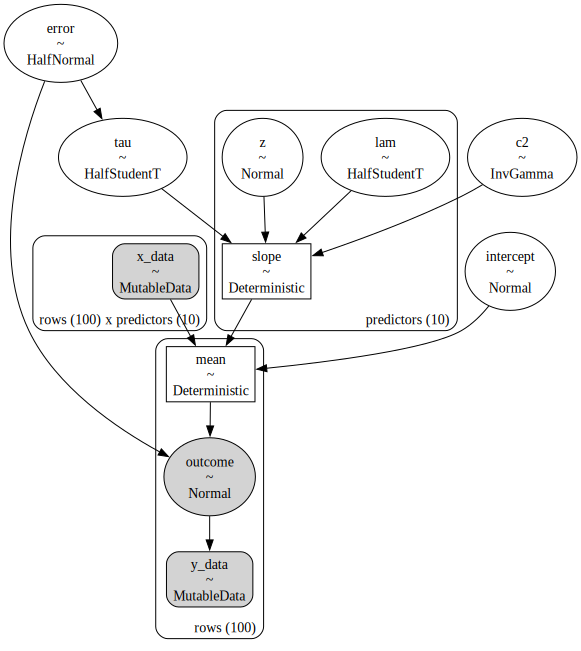

In [34]:
# View model diagram
pm.model_to_graphviz(regularized_model)

In [35]:
# Draw posterior samples
with regularized_model:
    regularized_posterior = pm.sample(target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, error, tau, lam, c2, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [36]:
# Sample outcome variable from posterior
with regularized_model:
    pm.sample_posterior_predictive(regularized_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


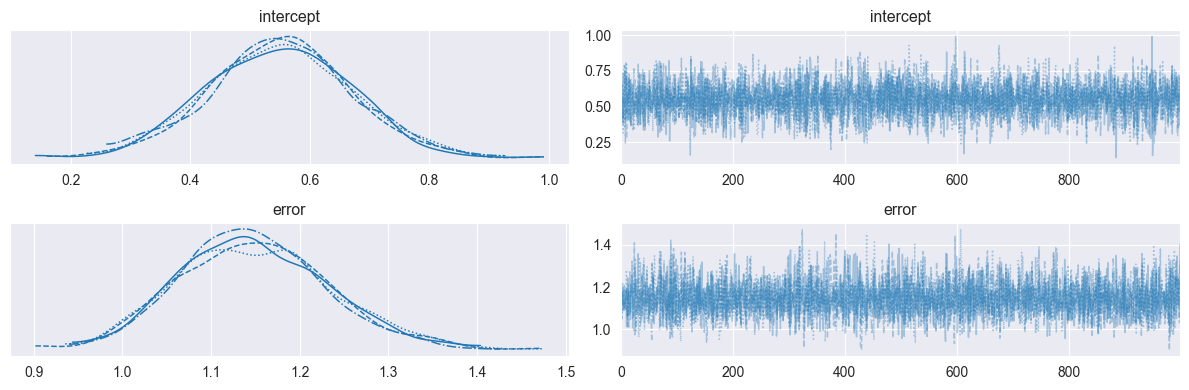

In [37]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    regularized_posterior,
    var_names = ["intercept", "error"]
)

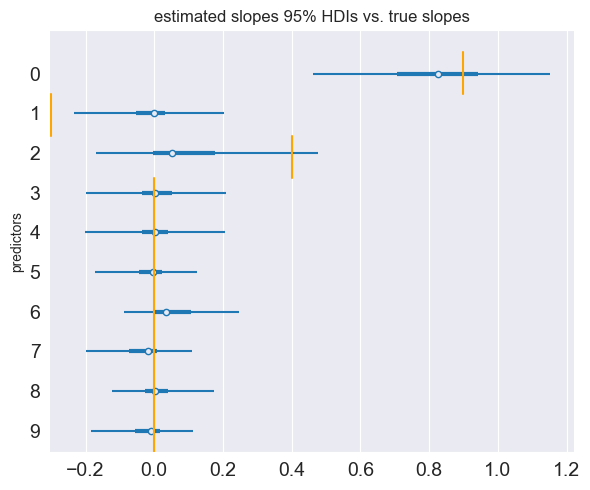

In [38]:
# Plot distributions for slope estimates
_ = pm.plot_forest(
    regularized_posterior,
    var_names=["slope"],
    combined=True,
    labeller=az.labels.NoVarLabeller(),
    hdi_prob = 0.95
    #kind = "ridgeplot",
    #ridgeplot_alpha = 0.3
)
_ = plt.axvline(true_slopes[0], ymin = 0.85, ymax = 0.95, c = "orange")
_ = plt.axvline(true_slopes[1], ymin = 0.75, ymax = 0.85,  c = "orange")
_ = plt.axvline(true_slopes[2], ymin = 0.65, ymax = 0.75,  c = "orange")
_ = plt.axvline(0, ymin = 0, ymax = 0.65, c = "orange")
_ = plt.title("estimated slopes 95% HDIs vs. true slopes")
_ = plt.ylabel("predictors")

In [39]:
# Simulate fitted regression lines
regularized_fitted = regularized_posterior.posterior["mean"]

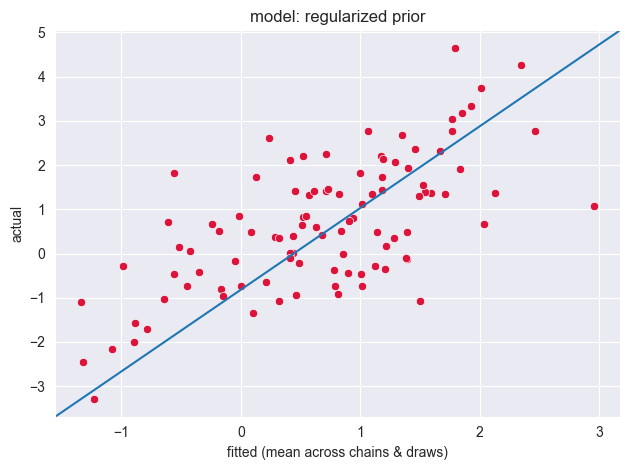

In [40]:
# Plot fitted vs. actual values

fig, ax = plt.subplots(1)
_ = sns.scatterplot(
    x = regularized_fitted.mean(("chain", "draw")), 
    y = y, 
    color = "crimson", 
    ax = ax)
_ = ax.plot([0, 1], [0, 1], transform=ax.transAxes)
_ = ax.set_xlabel("fitted (mean across chains & draws)")
_ = ax.set_ylabel("actual")
_ = ax.set_title("model: regularized prior")

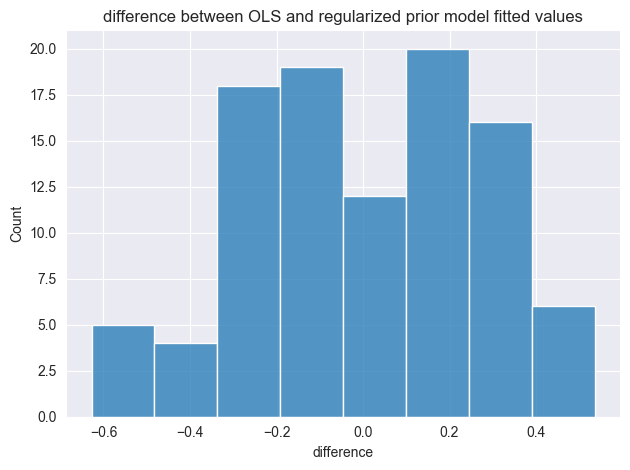

In [41]:
# Considerably different fitted values as OLS
_ = sns.histplot(ols_fitted - regularized_fitted.mean(("chain", "draw")))
_ = plt.title("difference between OLS and regularized prior model fitted values")
_ = plt.xlabel("difference")

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


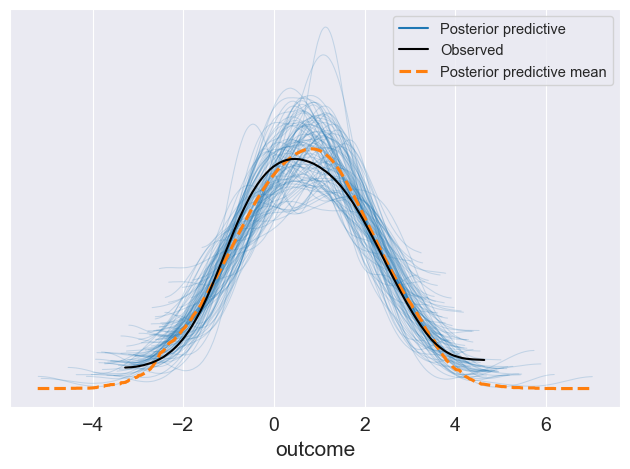

In [42]:
# Plot posterior distribution
_ = az.plot_ppc(regularized_posterior, num_pp_samples = 100)

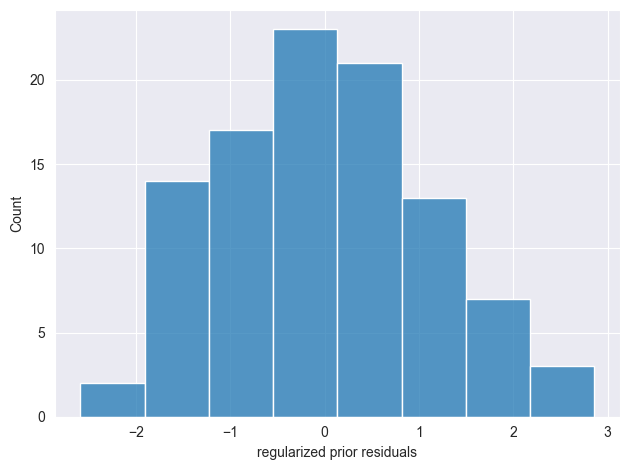

In [43]:
regularized_resids = y - regularized_fitted.mean(("chain", "draw"))
_ = sns.histplot(regularized_resids)
_ = plt.xlabel("regularized prior residuals")

In [44]:
print(f"RMSE regularized fitted: {np.round(np.sqrt(np.mean(regularized_resids**2)), 2)}" )

RMSE regularized fitted: 1.1
